# Going Deeper 6. Class Activation Map 만들기
# Step 0. 필요한 라이브러리 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

# Step 1. 데이터셋 준비하기

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

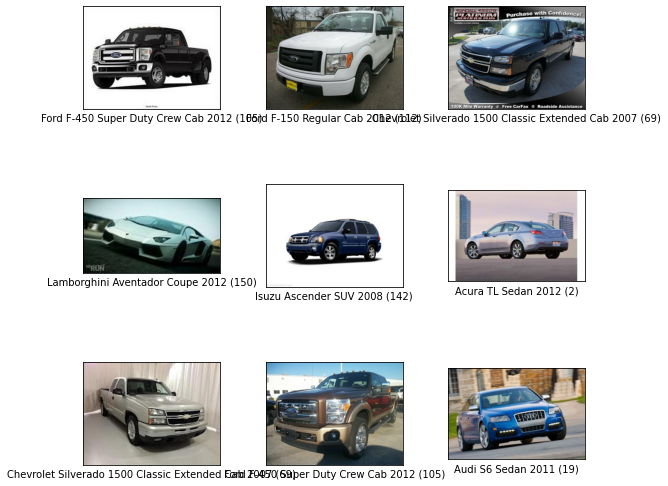

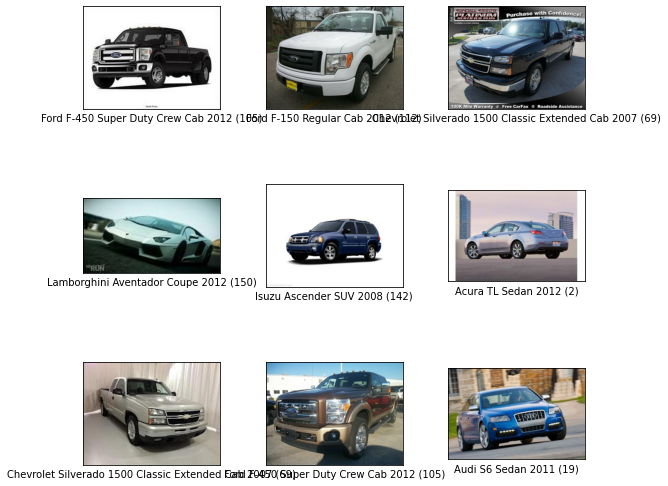

In [4]:
tfds.show_examples(ds_train, ds_info)

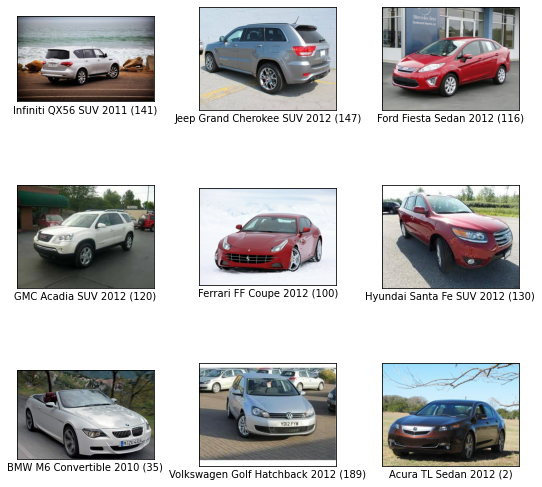

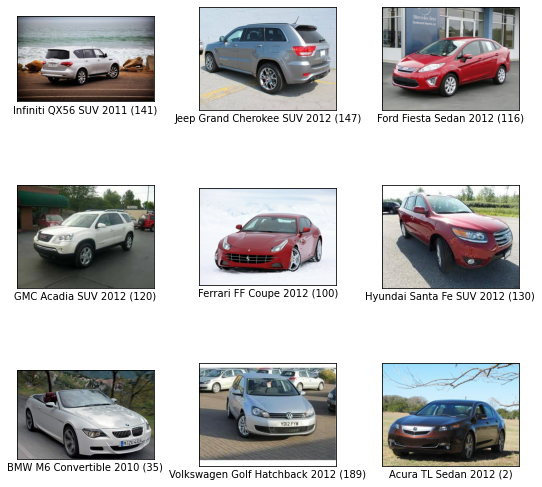

In [5]:
tfds.show_examples(ds_test, ds_info)

# Step 2. 물체의 위치정보

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

# Step 3. CAM을 위한 모델 만들기

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Step 4. CAM 모델 학습하기

In [8]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [10]:
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 126s 224ms/step - loss: 4.1529 - accuracy: 0.1698 - val_loss: 5.4354 - val_accuracy: 0.0075
Epoch 2/15
509/509 [==============================] - 115s 226ms/step - loss: 1.6707 - accuracy: 0.6359 - val_loss: 1.8270 - val_accuracy: 0.5350
Epoch 3/15
509/509 [==============================] - 117s 230ms/step - loss: 0.5901 - accuracy: 0.8919 - val_loss: 1.2476 - val_accuracy: 0.6780
Epoch 4/15
509/509 [==============================] - 117s 230ms/step - loss: 0.1651 - accuracy: 0.9850 - val_loss: 1.1393 - val_accuracy: 0.6983
Epoch 5/15
509/509 [==============================] - 118s 231ms/step - loss: 0.0574 - accuracy: 0.9974 - val_loss: 1.0163 - val_accuracy: 0.7250
Epoch 6/15
509/509 [==============================] - 118s 231ms/step - loss: 0.0344 - accuracy: 0.9983 - val_loss: 1.0025 - val_accuracy: 0.7300
Epoch 7/15
509/509 [==============================] - 118s 231ms/step - loss: 0.0307 - accuracy: 0.9988 - val_loss: 0.9898 -

In [13]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Step 5. CAM
## 5.1 CAM 생성 준비1

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

130


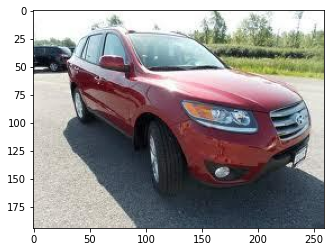

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [16]:
cam_model = tf.keras.models.load_model(cam_model_path)

## 5.2 CAM 생성조건

In [17]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

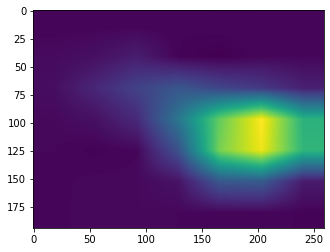

In [18]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

## 5.3 원본 이미지와 CAM이미지 합성

In [19]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

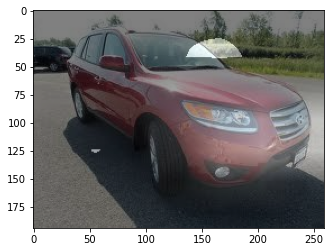

In [20]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

# Step 6. Grad-CAM

121


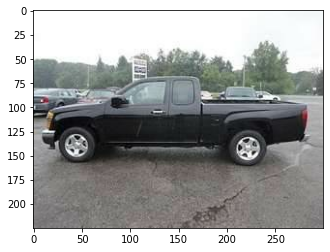

In [21]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

## 6.1 Grad-CAM을 이용해서 CAM을 만드는 과정

In [22]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

## 6.2 generate_grad_cam()로 여러 레이어의 CAM 이미지를 뽑아서 출력

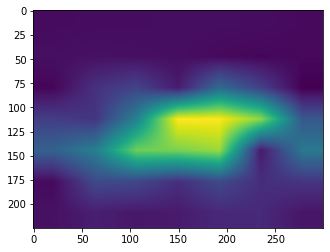

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

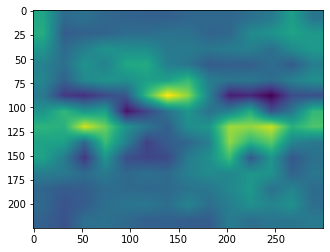

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

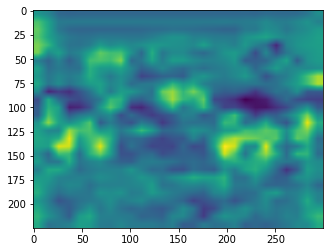

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

# Step 7. Detection with CAM
## 7.1 get_bbox() 함수

In [26]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [27]:
rect = get_bbox(cam_image)
rect

array([[ 20, 154],
       [ 37,  26],
       [271,  59],
       [253, 186]])

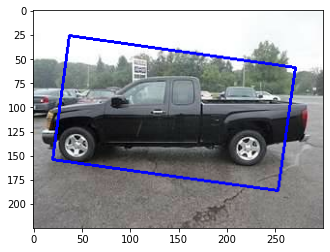

In [28]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## 7.2 Intersection Over Union

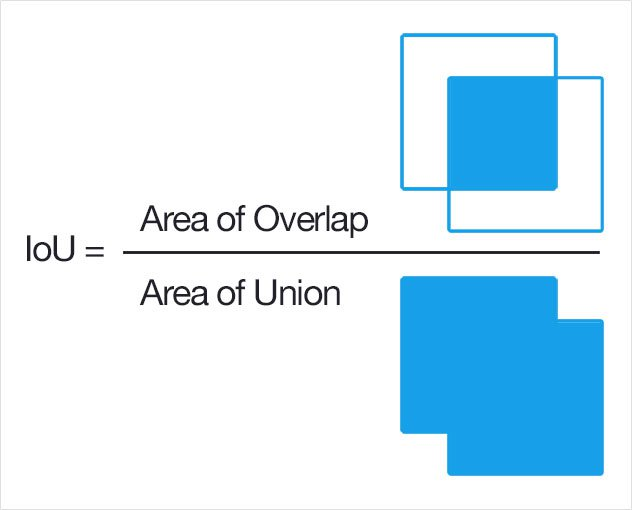

In [29]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [30]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.11555555555555555,
 0.06666666666666667,
 0.8266666666666667,
 0.9033333333333333]

In [31]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [32]:
get_iou(pred_bbox, item['bbox'])

0.5470460273779865

# Step 8. 성능비교

12


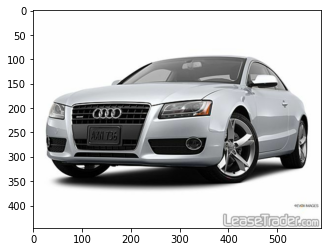

In [33]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

## 8.1 CAM

In [34]:
cam_image = generate_cam(cam_model, item)

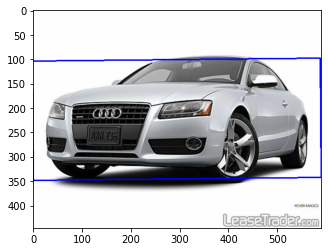

In [35]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [36]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['bbox'])

0.8768255870527699

## 8.2 Grad_CAM

In [37]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', item)

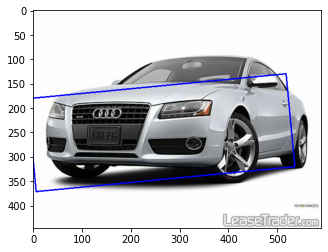

In [38]:
image = copy.deepcopy(item['image'])
rect_g = get_bbox(grad_cam_image)

image = cv2.drawContours(image,[rect_g],0,(0,0,255),2)
plt.imshow(image)

In [39]:
pred_bbox = rect_to_minmax(rect_g, item['image'])
get_iou(pred_bbox, item['bbox'])

0.7046667658328387

# 결과
- CAM 과 Grad-CAM로 구한 IoU 가 둘 다 상당히 높은 수준으로 나온 것을 확인 할 수 있다. 그 이유는 아마 테스트 과정에서 사용된 자동차 이미지의 노이즈가 적고, 차의 주요 특징적인 부분이 잘 묘사되어있는 것으로 보인다.

# 회고
- IoU값을 조금 더 높여보고 싶었으나 시간이...
- IoU를 높일 방법을 한번 찾아봐야겠다..